Testing: 100%|██████████| 276/276 [00:24<00:00, 11.04it/s]


F1-Score: 0.9986
Precision: 0.9986
Recall: 0.9986

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       252
                                 Apple___Black_rot       1.00      1.00      1.00       249
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       220
                                   Apple___healthy       1.00      1.00      1.00       251
                               Blueberry___healthy       1.00      1.00      1.00       227
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       211
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       229
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.98      0.99       206
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       239
     

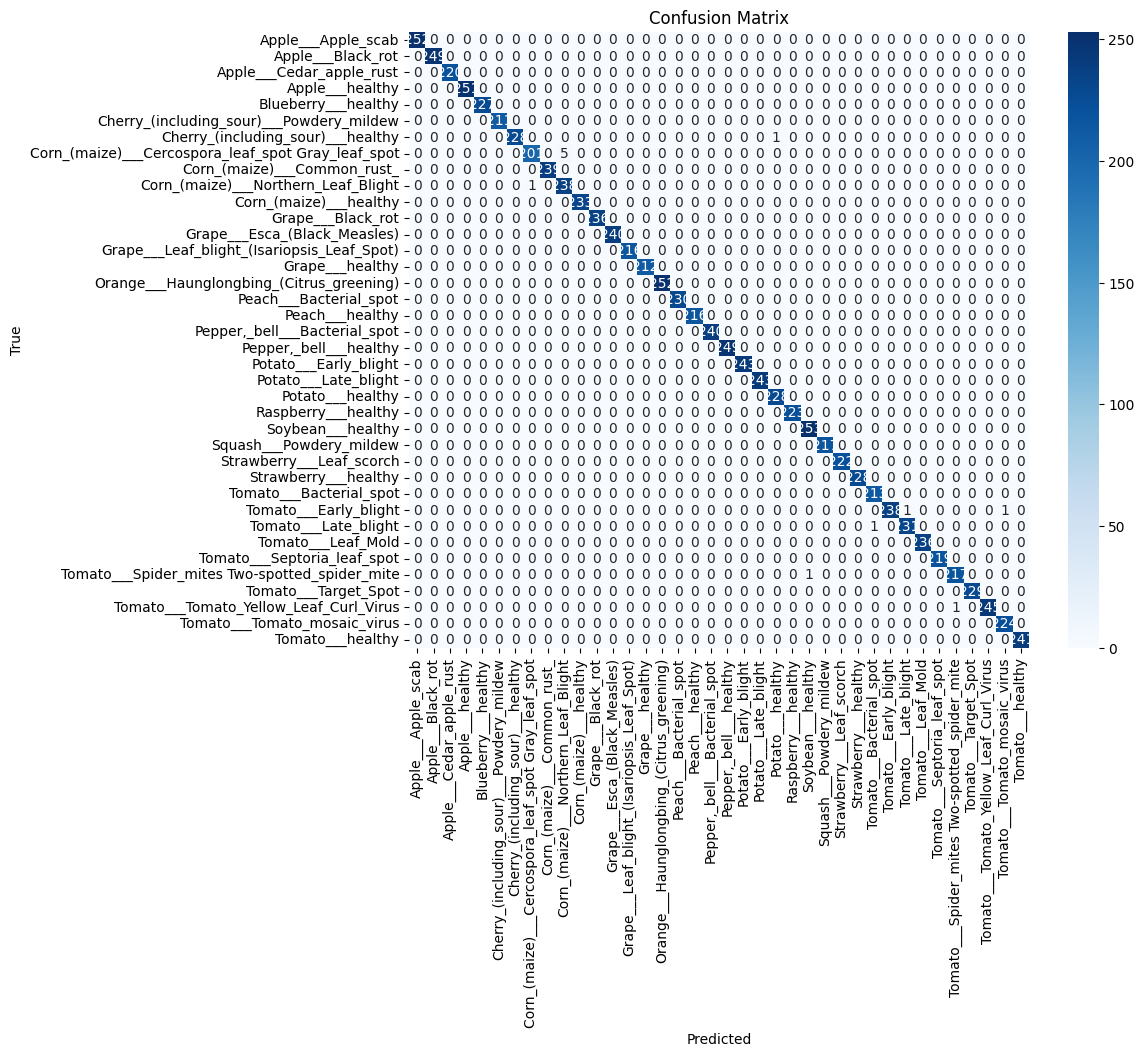

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

train_path = r"D:\PlantMaster\Dataset\DuzenlenmisPG-tts\train"
test_path = r"D:\PlantMaster\Dataset\DuzenlenmisPG-tts\test"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

val_test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

model_path= r"D:\PlantMaster\PlantMaster_Model\modeller\mobilnet\best_plant_disease_model_mobilenet.pth"

model.load_state_dict(torch.load(model_path))

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

f1 = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("mobilenet_confusion_matrix.png")
plt.show()